In [2]:
from torchvision import datasets
import numpy as np
import pandas as pd
from torch import optim
import torch
CUDA_LAUNCH_BLOCKING=1
from torchvision import models
import torch.nn as nn
import os
import tqdm
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import skimage
from skimage.color import rgb2gray, gray2rgb
import cv2
import gc
from sklearn.metrics import mean_squared_error

In [3]:
def crop_desired_region(img_):
    
    coords = cv2.findNonZero(img_) 
    x, y, w, h = cv2.boundingRect(coords) 
    rect = img_[y:y+h, x:x+w] 
    rect_originalSized = cv2.resize(rect,(img_.shape))
    return rect_originalSized

def center_crop(img, set_size):
    h, w, c = img.shape
    if set_size > min(h, w):
        return img
    crop_width = set_size
    crop_height = set_size
    mid_x, mid_y = w//2, h//2
    offset_x, offset_y = crop_width//2, crop_height//2
    crop_img = img[mid_y - offset_y:mid_y + offset_y, mid_x - offset_x:mid_x + offset_x]
    return crop_img

def normalize(img: np.ndarray) -> np.ndarray:
    
    return (img - img.min()) / (img.max() - img.min())

'''
def preproc_tabular(df,root_dir):
    df['filename'] = root_dir+'/'+df.patient_id.astype(str)+'/'+df.image_id.astype(str)+'.png'
    train_selected = df.drop(['patient_id','image_id','cancer','filename','laterality','view'],axis=1)
    train_selected.BIRADS.fillna('7',inplace = True)
    train_selected.BIRADS = train_selected.BIRADS.astype('category')
    train_selected.density.fillna('K',inplace = True)
    train_selected.density = train_selected.density.astype('category')
    train_input = pd.get_dummies(train_selected)
    return(train_input)

def preproc_tabular_test(df,root_dir):
    df['filename'] = root_dir+'/'+df.patient_id.astype(str)+'/'+df.image_id.astype(str)+'.png'
    train_selected = df.drop(['patient_id','image_id','filename','laterality','view'],axis=1)
    train_input = pd.get_dummies(train_selected)
    return(train_input)
'''

def preproc_image(img_name):
    
    image = io.imread(img_name)
    image = crop_desired_region(image)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  
#     image = center_crop(image,100)
    image = normalize(image)
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    return(image)

In [4]:
class RSNADataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.tabular = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        tabular_tmp = self.tabular
        
        img_name = tabular_tmp.filename.tolist()[idx]
        image = preproc_image(img_name)
        target = torch.Tensor(tabular_tmp['cancer'].tolist())[idx]
        sample = {'image': image,'answer':target}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [5]:
class RSNADataset_Test(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        self.tabular = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.tabular)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        tabular_tmp = self.tabular
        
        img_name = tabular_tmp.filename.tolist()[idx]
        image = preproc_image(img_name)
        sample = {'image': image}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

In [6]:
def evaluation(dataloader):
    predictions = torch.tensor([], dtype=torch.float).cuda() 
    actual = torch.tensor([], dtype=torch.float).cuda() 
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            inputs, values = data['image'].float().cuda(),data['answer'].cuda()
            outputs = model(inputs).cuda()
            predictions = torch.cat((predictions, torch.stack([torch.argmax(o) for o in outputs])),0)
            actual = torch.cat((actual, values), 0)
    
    predictions = predictions.cpu().numpy()
    actual = actual.cpu().numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))
    return rmse

In [38]:
def show_prep_image(img_name):

    plt.figure(figsize = (30,16))
    
    plt.subplot(2,3,1)
    image = io.imread(img_name)
    #plt.imshow(image)
    #plt.title('Оригинальное изображение')
    
    #plt.subplot(2,3,2)
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
    #plt.title('Изображение в оттенках серого цвета')
    
    
    plt.subplot(2,3,1)
    image = crop_desired_region(image)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
    plt.title('Обрезанное изображение(cropped)')
    
    plt.subplot(2,3,2)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = normalize(image)
    plt.imshow(image)
    plt.title('Изображение с нормализацией')
    
    plt.tight_layout()
    return(0)

0

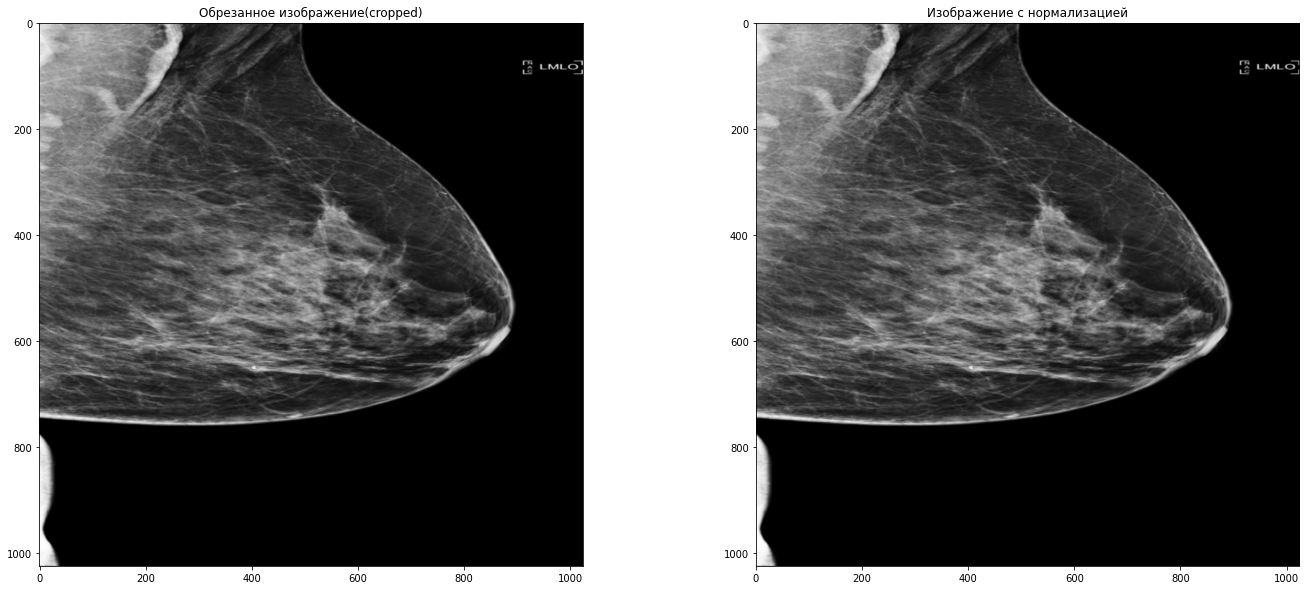

In [39]:
test_file = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/10226/461614796.png'
show_prep_image(test_file)

0

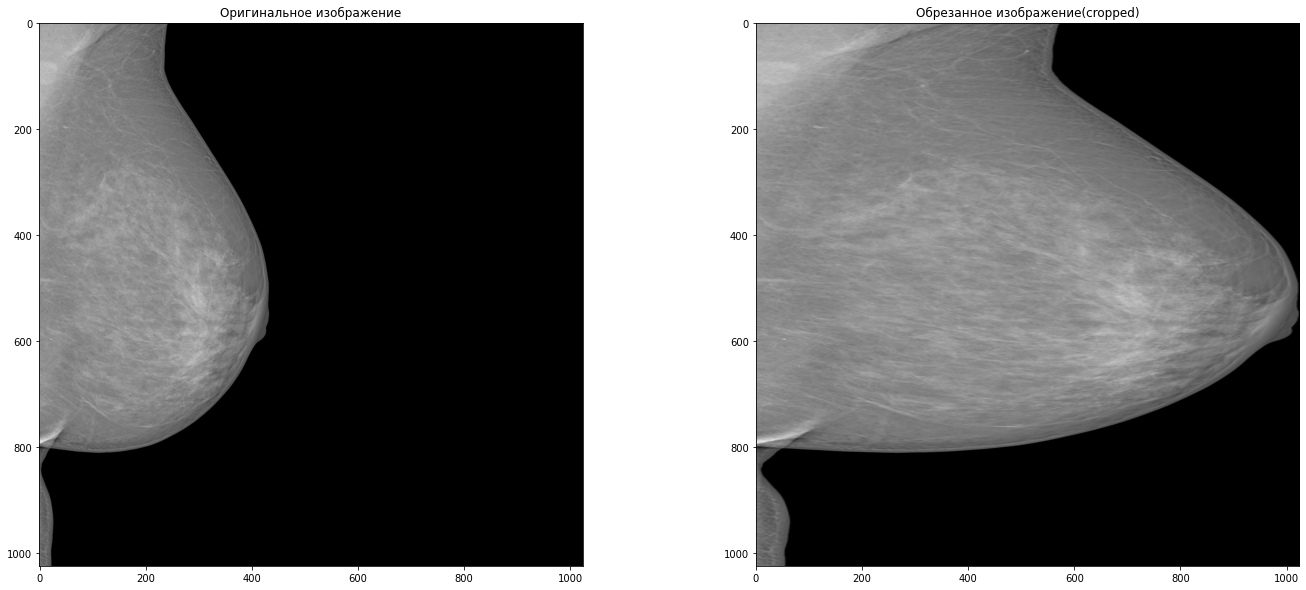

In [23]:
test_file = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/10025/1365269360.png'
show_prep_image(test_file)

In [24]:
lr = 1e-06
num_epochs = 1
batch_size = 4

csv ='/kaggle/input/rsna-breast-cancer-detection/train.csv'
# rootpath = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_1024/train_images_processed_1024/'
rootpath = '/kaggle/input/rsna-mammography-images-as-pngs/images_as_pngs_cv2_256/train_images_processed_cv2_256/'
rsna_dataset = RSNADataset(csv_file=csv,root_dir=rootpath)

train_rsna_set, val_rsna_set = torch.utils.data.random_split(rsna_dataset,[44706,10000])

train_rsna_dataloader = DataLoader(train_rsna_set, batch_size=batch_size, shuffle=True)
val_rsna_dataloader = DataLoader(val_rsna_set, batch_size=batch_size, shuffle=True)


In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet50(pretrained=True) 
model = torch.load('/kaggle/input/pytorch-pretrained/resnet50-0676ba61.pth')
# model.fc = nn.Sequential(nn.Linear(512,2),nn.Softmax()) # ResNet18
model.fc = nn.Sequential(nn.Linear(2048,2),nn.Softmax()) # ResNet50

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_function = nn.BCEWithLogitsLoss().to(device)
num_epoch = 1
params = {
    'num_epochs':num_epochs,
    'optimizer':optimizer,
    'loss_function':loss_function,
    'train_dataloader':train_rsna_dataloader,
    'val_dataloader': val_rsna_dataloader,
    'device':device,
    'num_epoch' : num_epoch
}

In [26]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=3, shuffle=True)

In [27]:

torch.cuda.empty_cache()
gc.collect()

19908

In [29]:
 def train(model, params):
    soft = nn.Softmax()
    loss_function=params["loss_function"]
    train_dataloader=params["train_dataloader"]
    val_dataloader=params["val_dataloader"]
    device=params["device"]
    for epoch in range(0, num_epochs):
        for dat in train_rsna_dataloader:
            inputs = dat['image'].float().cuda()
            labels = dat['answer'].cuda()
            
            optimizer.zero_grad() 
            outputs = model(inputs)
            outputs = torch.stack([torch.argmax(o) for o in outputs])
            
            train_loss = loss_function(outputs.float(),labels.float())
            train_loss = train_loss.requires_grad_(True)
            train_loss.backward()
            optimizer.step()
            print('Epoch: %d/%d, Train loss: %.6f' %(epoch+1, num_epochs, train_loss.item()))


    total = 0
    correct = 0
    accuracy = []
    for i, data in enumerate(val_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_loss = loss_function(outputs, labels).item()
        accuracy.append(100 * correct/total)    
        print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f' %(epoch+1, num_epochs, train_loss.item(), test_loss, 100*correct/total))
        
    import gc
    torch.cuda.empty_cache()
    gc.collect()
    return(0)


train(model, params)

Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.003204
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.313262
Epoch: 1/1, Train loss: 1.313262
Epoch: 1/1, Train loss: 1.003204
Epoch: 1/1, Train loss: 0.908233
Epoch: 1/1, Train loss: 1.313262
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.313262
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.003204
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.003204
Epoch: 1/1, Train loss: 1.313262
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.158233
Epoch: 1/1, Train loss: 1.003204
Epoch: 1/1

AttributeError: 'str' object has no attribute 'to'

In [ ]:
batch_size = 128
soft = nn.Softmax()
model.train()
validation_loss = []
#Kfold
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_rsna_set)): 
    
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx) 
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx) 
    
    
    trainloader = torch.utils.data.DataLoader(train_rsna_set, batch_size=batch_size, sampler=train_subsampler)
    valloader = torch.utils.data.DataLoader(train_rsna_set, batch_size=batch_size, sampler=val_subsampler)
    
    loss_function=params["loss_function"]
    train_dataloader=params["train_dataloader"]
    val_dataloader=params["val_dataloader"]
    device=params["device"]
    num_epochs = params['num_epochs']
    
    for epoch in range(0, num_epochs):
        for i_batch,dat in enumerate(tqdm.tqdm(trainloader)):
            inputs = dat['image'].float().cuda()
            labels = dat['answer'].cuda()
            
            optimizer.zero_grad() 
            outputs = model(inputs)
            outputs = torch.stack([torch.argmax(o) for o in outputs])
            
            train_loss = loss_function(outputs.float(),labels.float())
            train_loss = train_loss.requires_grad_(True)
            train_loss.backward()
            optimizer.step()

    train_rmse = evaluation(trainloader) 
    val_rmse = evaluation(valloader)
    print("k-fold", fold," Train Loss: %.4f, Validation Loss: %.4f" %(train_rmse, val_rmse)) 
    validation_loss.append(val_rmse)

validation_loss = np.array(validation_loss)
mean = np.mean(validation_loss)
std = np.std(validation_loss)
print("Validation Score: %.4f, ± %.4f" %(mean, std))

In [30]:
accuracy

{'num_epochs': 1,
 'optimizer': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     eps: 1e-08
     lr: 1e-06
     maximize: False
     weight_decay: 0
 ),
 'loss_function': BCEWithLogitsLoss(),
 'train_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7828e08a6690>,
 'val_dataloader': <torch.utils.data.dataloader.DataLoader at 0x7828e0a18150>,
 'device': device(type='cuda'),
 'num_epoch': 1}

In [ ]:
csv_test = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
rootpath_test = '/kaggle/input/rsna-test-dicomtopng-files/Test_DICOM_PNGs/test_images_processed_256/'
rsna_dataset_test = RSNADataset_Test(csv_file = csv_test,root_dir = rootpath_test)
test_rsna_dataloader = DataLoader(rsna_dataset_test, batch_size=batch_size)

In [ ]:
output_lst=[]
for i_batch,dat in enumerate(tqdm.tqdm(test_rsna_dataloader)):
    inputs = dat['image'].float().cuda()
    outputs = model(inputs)
    outputs = torch.stack([o[1].cpu() for o in outputs])
    outputs_transform = outputs.detach().numpy()
    

In [ ]:
submission_base_tab = rsna_dataset_test.tabular
submission_out = pd.DataFrame(outputs_transform)

In [ ]:
submission = pd.concat([submission_base_tab,submission_out],axis=1)[['prediction_id',0]]
submission.columns = ['prediction_id','cancer']
submission.to_csv('submission.csv')

In [ ]:
submission

In [ ]:
# def train(model, params):
#     soft = nn.Softmax()
#     loss_function=params["loss_function"]
#     train_dataloader=params["train_dataloader"]
#     val_dataloader=params["val_dataloader"]
#     device=params["device"]
#     for epoch in range(0, num_epochs):
#         for dat in rsna_dataloader:
#             inputs = dat['image'].float().cuda()
#             labels = dat['answer'].cuda()
            
#             optimizer.zero_grad() 
#             outputs = model(inputs)
#             outputs = torch.stack([torch.argmax(o) for o in outputs])
            
#             train_loss = loss_function(outputs.float(),labels.float())
#             train_loss = train_loss.requires_grad_(True)
#             train_loss.backward()
#             optimizer.step()
# #             print('Epoch: %d/%d, Train loss: %.6f' %(epoch+1, num_epochs, train_loss.item()))

#   
#     total = 0
#     correct = 0
#     accuracy = []
#     for i, data in enumerate(val_dataloader, 0):
#         inputs, labels = data
#         inputs = inputs.to(device)
#         labels = labels.to(device)

#         outputs = model(inputs)

#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
#         test_loss = loss_function(outputs, labels).item()
#         accuracy.append(100 * correct/total)    
#         print('Epoch: %d/%d, Train loss: %.6f, Test loss: %.6f, Accuracy: %.2f' %(epoch+1, num_epochs, train_loss.item(), test_loss, 100*correct/total))
        
#     import gc
#     torch.cuda.empty_cache()
#     gc.collect()
#     return(0)


# train(model, params)